In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random
import math

In [4]:
data = pd.read_csv("A2Q1.csv")
data = np.array(data)
n = len(data) # No. of data points
d = 50 # dimensions
k = 4 # No. of Mixtures
epsilon = 1e-10  # Small epsilon value

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## i. EM Algorithm with Bernoulli Mixture

In [18]:
def init_bern(u,p):
    sum = 0.0
    for i in range(k):
        for j in range(d):
            u[i][j] = random.random()
        p[i] = random.random()
        sum += p[i]
    for i in range(k):
        p[i] /= sum

def f_bern(x,p):
    sum = 0.0
    for i in range(d):
        sum += (p[i]**x[i])*((1-p[i])**(1-x[i]))
    return sum

def Log_Likelihood_bern(u,p):
    ans = 0.0
    for i in range(n):
        sum = 0.0
        for j in range(k):
            sum += p[j]*f_bern(data[i],u[j])
        ans += np.log(sum)
    return ans

0.5
0.33333333333333337
0.24999999999999997
0.20000000000000007
0.16666666666666663
0.14285714285714282
0.12499999999999999
0.11111111111111109
0.09999999999999999
0.0909090909090909
0.08333333333333343
0.07692307692307691
0.07142857142857141
0.06666666666666665
0.06249999999999999
0.0588235294117647
0.055555555555555546
0.05263157894736841
0.049999999999999996
0.047619047619047616
0.04545454545454545
0.04347826086956531
0.04166666666666666
0.039999999999999994
0.03846153846153846
0.03703703703703703
0.035714285714285705
0.03448275862068965
0.033333333333333326
0.032258064516129024
0.031249999999999997
0.030303030303030297
0.02941176470588235
0.028571428571428567
0.027777777777777773
0.027027027027027025
0.026315789473684206
0.025641025641025637
0.024999999999999998
0.024390243902439022
0.023809523809523808
0.02325581395348837
0.022727272727272724
0.022222222222222327
0.021739130434782605
0.021276595744680847
0.02083333333333333
0.020408163265306117
0.019999999999999997
0.0196078431372

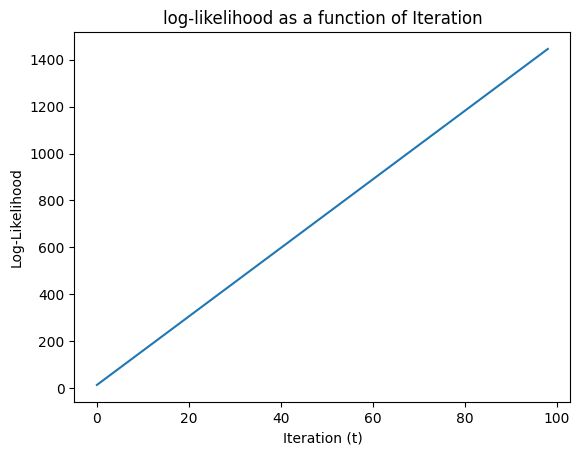

In [20]:
u_bern = np.zeros((k,d))
p_bern = np.zeros((k))
log_likelihood_bern = np.zeros((100000))
tolerance_bern = 0.01

for l in range(100):
    count = 0
    log_likelihood_temp = np.zeros((100000))
    init_bern(u_bern,p_bern)
    while True:
        z_bern = np.zeros((n,k))
        
        # Expectation Step
        for i in range(n):
            sum = 0.0
            for j in range(k):
                sum += p_bern[j]*f_bern(data[i],u_bern[j])
            for j in range(k):
                z_bern[i][j] = (p_bern[j]*f_bern(data[i],u_bern[j]))/sum

        # Maximization Step
        for i in range(k):
            p_bern[i] = 0.0
            for j in range(n):
                p_bern[i] += z_bern[j][i]
            p_bern[i] /= n

        for i in range(k):
            sum = 0.0
            u_bern[i] = 0.0
            for j in range(n):
                sum += z_bern[j][i]
                u_bern[i] += z_bern[j][i]*data[j]
            if sum != 0.0: u_bern[i] /= sum

        log_likelihood_temp[count] = Log_Likelihood_bern(u_bern,p_bern)
        if count != 0: log_likelihood_bern[count] = log_likelihood_bern[count-1] + log_likelihood_temp[count]
        else: log_likelihood_bern[count] = log_likelihood_temp[count]

        # Convergence Criteria 
        if count != 0:
            error_bern = (log_likelihood_bern[count] - log_likelihood_bern[count-1])/log_likelihood_bern[count]
            if error_bern < tolerance_bern:
                break
            print(error_bern)
        count += 1

log_likelihood_bern /= 100

# print(count)
log_likelihood_bern = log_likelihood_bern[log_likelihood_bern != 0]
# print(log_likelihood_bern)

plt.plot(log_likelihood_bern[:99])
plt.xlabel('Iteration (t)')
plt.ylabel('Log-Likelihood')
plt.title('log-likelihood as a function of Iteration')
plt.show()

## ii. EM Algorithm with Gaussian Mixture

In [5]:
def init_gauss_random(data, k):
    # Initialize means randomly
    u_gauss = np.random.uniform(low=np.min(data), high=np.max(data), size=(k, data.shape[1]))

    # Initialize covariance matrices as identity matrices
    sig = np.tile(np.eye(data.shape[1])[np.newaxis], (k, 1, 1))

    sum = 0.0
    p_gauss = np.zeros((k))
    for i in range(k):
        p_gauss[i] = random.random()
        sum += p_gauss[i]
    for i in range(k):
        p_gauss[i] /= sum

    return u_gauss, sig, p_gauss

def f_gauss(x,u,sig):
    sig_inv = np.linalg.pinv(sig)  # Compute the pseudoinverse of the covariance matrix
    exponent = -0.5 * (x - u).T @ sig_inv @ (x - u)
    det_sig = np.linalg.det(sig)
    if det_sig <= 0:
        return 0  # Avoid negative or zero determinant
    else:
        denominator = np.sqrt((2 * np.pi) ** d * det_sig)
        return np.exp(exponent) / denominator

def Log_Likelihood_gauss(u,sig,p):
    ans = 0.0
    for i in range(n):
        temp = 0.0
        for j in range(k):
            gauss_val = f_gauss(data[i], u[j], sig[j])
            if gauss_val == 0:
               temp += 0  # Avoid division by zero
            else:
               temp += p[j] / max(gauss_val, 1e-6)
        if temp == 0:
            continue
        ans += np.log(temp)
    return (ans)

In [ ]:
u_gauss = np.zeros((k,d))
sig = np.zeros((k,d,d))
p_gauss = np.zeros((k))
log_likelihood_gauss = np.zeros((1000))
tolerance_gauss = 0.1
    
for l in range(100):
    count_gauss = 0
    log_likelihood_temp = np.zeros((1000))
    u_gauss, sig, p_gauss = init_gauss_random(data, k)
    while True:
        lamda = np.zeros((n,k))
    
        # Expectation step
        for i in range(n):
            sum_lamda = 0.0
            for j in range(k):
                lamda[i][j] = f_gauss(data[i], u_gauss[j], sig[j]) * p_gauss[j]
                sum_lamda += lamda[i][j]
            if sum_lamda == 0:
                lamda[i] = [1/k] * k
            else:
                lamda[i] /= sum_lamda
        
        #Maximization step
        for i in range(k):
            # Update mixing coefficients
            p_gauss[i] = np.sum(lamda[:, i]) / n
            
            # Update means
            if np.sum(lamda[:, i]) == 0:
                # If no points assigned to this cluster, randomly initialize the mean
                u_gauss[i] = np.random.rand(d)
            else:
                # Otherwise, compute the weighted mean of points assigned to this cluster
                u_gauss[i] = np.sum(data * lamda[:, i][:, None], axis=0) / np.sum(lamda[:, i])
            
            # Update covariance matrices
            sum_sig = np.zeros((d, d))
            for j in range(n):
                sum_sig += lamda[j][i] * np.outer(data[j] - u_gauss[i], data[j] - u_gauss[i])
            if np.sum(lamda[:, i]) == 0:
                # If no points assigned to this cluster, set covariance matrix to identity matrix
                sig[i] = np.eye(d)
            else:
                # Otherwise, compute the weighted covariance matrix
                sig[i] = np.linalg.pinv(sum_sig / np.sum(lamda[:, i]))
    
        log_likelihood_temp[count_gauss] = Log_Likelihood_gauss(u_gauss,sig,p_gauss)
        if count_gauss != 0: log_likelihood_gauss[count_gauss] = log_likelihood_gauss[count_gauss-1] + log_likelihood_temp[count_gauss]
        else: log_likelihood_gauss[count_gauss] = log_likelihood_temp[count_gauss]
    
        # Convergence Criteria 
        if count_gauss != 0:
            error_gauss = (log_likelihood_gauss[count_gauss] - log_likelihood_gauss[count_gauss-1])/max(log_likelihood_gauss[count_gauss], 1e-6)
            if error_gauss < tolerance_gauss:
                break
            # print(error_gauss)
        count_gauss += 1

    print(l)

log_likelihood_gauss /= 100

10
[ 55.26204223 110.52408446 165.7861267  221.04816893 276.31021116
 331.57225339 386.83429562 442.09633785 497.35838009 552.62042232
 607.88246455]


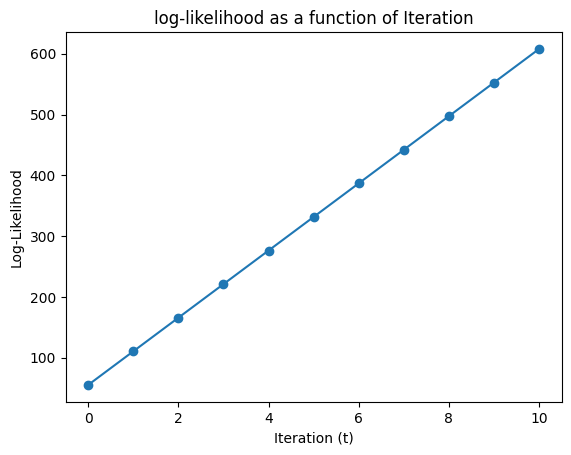

In [8]:
print(count_gauss)
log_likelihood_gauss = log_likelihood_gauss[log_likelihood_gauss != 0]
print(log_likelihood_gauss)

plt.plot(log_likelihood_gauss,marker = 'o')
plt.xlabel('Iteration (t)')
plt.ylabel('Log-Likelihood')
plt.title('log-likelihood as a function of Iteration')
plt.show()

In [ ]:
# Plotting both log-likelihood curves
plt.plot(log_likelihood_bern, label='Bernoulli Mixture')
plt.plot(log_likelihood_gauss, label='Gaussian Mixture')

# Adding labels and legend
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood Comparison')
plt.legend()

# Display the plot
plt.show()

## iii. K-Means Algorithm with K = 4

In [10]:
def init(z):
    for i in range(n):
        z[i] = random.randint(0,3)
    return z

def Error(data,z,mean):
    ans = 0
    for i in range(n):
        ans += np.linalg.norm(data[i]-mean[int(z[i])])**2
    return ans

[2242.09275634 1925.26294657 1760.1239645  1750.68570234 1747.89286117
 1746.33647703 1744.91362222 1744.01798569 1743.70188647 1743.3803324 ]


Text(0, 0.5, 'Objective Function')

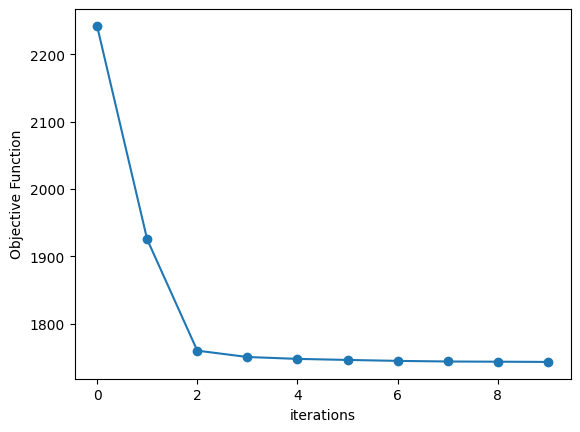

In [23]:
def K_Means(data,error,k):
   iteration = 0 
   z = np.zeros((n))
   init(z)
   while True:
       mean = np.zeros((k,d))
       cnt = np.zeros((k))
       for i in range(n):
           x = int(z[i])
           mean[x] += data[i]
           cnt[x] += 1
       for i in range(k):
           if cnt[i]==0: cnt[i]=1
           mean[i] = mean[i]/cnt[i]
       check = 0
       for i in range(n):
           temp1 = z[i]
           x = np.linalg.norm(data[i] - mean[int(z[i])]) ** 2
           for j in range(k):
               if np.linalg.norm(data[i] - mean[j]) ** 2 < x: 
                   z[i] = j
           if temp1==z[i]:
               check += 1
       if check==n:
           break
       error[iteration] = Error(data,z,mean)
       iteration += 1
   return z

error_K = np.zeros((n))
z = K_Means(data,error_K,k)
error_K = error_K[error_K != 0.0]
print(error_K)
plt.plot(error_K,marker = 'o')
plt.xlabel("iterations")
plt.ylabel("Objective Function")

## iv. Hard clustering for comparison

In [ ]:
z_gaussian = np.zeros((n))
for i in range(n):
    z_gaussian[i] = np.argmax(lamda[i])
mean_gaussian = np.zeros((k, d))
counts_gaussian = np.zeros(k, dtype=int)
for i in range(n):
    mean_gaussian[int(z_gaussian[i])] += data[i]
    counts_gaussian[int(z_gaussian[i])] += 1
for j in range(k):
    if counts_gaussian[j] != 0: mean_gaussian[j] /= counts_gaussian[j]

z_bernoulli = np.zeros((n))
for i in range(n):
    z_bernoulli[i] = np.argmax(z_bern[i])
mean_bernoulli = np.zeros((k, d))
counts_bernoulli = np.zeros(k, dtype=int)
for i in range(n):
    mean_bernoulli[int(z_bernoulli[i])] += data[i]
    counts_bernoulli[int(z_bernoulli[i])] += 1
for j in range(k):
    if counts_bernoulli[j] != 0: mean_bernoulli[j] /= counts_bernoulli[j]

In [ ]:
obj_gaussian = 0
for i in range(n):
    obj_gaussian += np.linalg.norm(data[i]-mean_gaussian[int(z_gaussian[i])])**2
print('Objective value for GMM is ',obj_gaussian)

obj_bernoulli = 0
for i in range(n):
    obj_bernoulli += np.linalg.norm(data[i]-mean_bernoulli[int(z_bernoulli[i])])**2
print('Objective value for BMM is ',obj_bernoulli)

print('objective value for K-Means is ', error_K[error_K.size-1])